# QSVM QOSF Task 4 – Quantum Support Vector Machine on Iris Dataset

**Author:** Boukabous Maria 
**Email:** mariaboukabous11@gmail.com
**Task:** QOSF Mentorship Screening – Task 4 (QSVM)  

---

### Objective
This notebook implements and compares two **Quantum Support Vector Machine (QSVM)** models on a binary classification problem using the Iris dataset.  

We explore:
- Data preprocessing and feature normalization
- Classical SVM baseline
- Two distinct QSVM circuits
- Decision boundaries and performance metrics
- Comparison between models

All plots and figures are saved in the `figures/` directory.


## Import Libraries

In [1]:
# ----- Classical ML & Data -----
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# ----- Quantum -----
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# ----- Utilities -----
import os
import pandas as pd
os.makedirs('figures', exist_ok=True)


## Load and Explore Data

 Data shape: (100, 2)
 Classes: [0 1]


,sepal length (cm),sepal width (cm),target
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
5,5.4,3.9,0
6,4.6,3.4,0
7,5.0,3.4,0
8,4.4,2.9,0
9,4.9,3.1,0


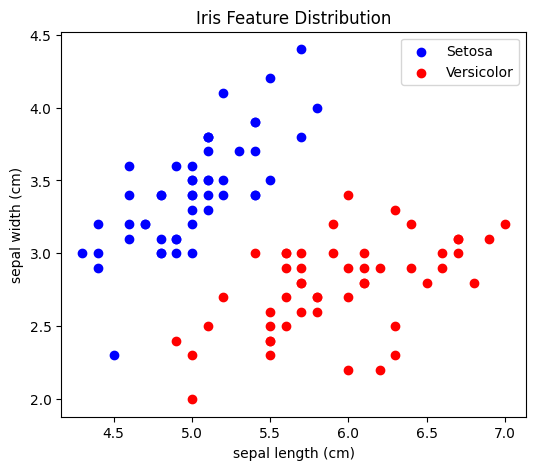

In [2]:
# ----- Load Iris dataset -----
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, :2]  # take first two features for visualization
Y = iris.target

# Keep only Setosa and Versicolor (binary classification)
mask = Y < 2
X = X[mask]
Y = Y[mask]

print(" Data shape:", X.shape)
print(" Classes:", np.unique(Y))

# ----- Display as table -----
feature_names = iris.feature_names[:2]  # first two features
df = pd.DataFrame(X, columns=feature_names)
df['target'] = Y
display(df.head(10))  # show first 10 rows

# ----- Scatter plot of features -----
plt.figure(figsize=(6,5))
plt.scatter(X[Y==0,0], X[Y==0,1], color='blue', label='Setosa')
plt.scatter(X[Y==1,0], X[Y==1,1], color='red', label='Versicolor')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Iris Feature Distribution")
plt.legend()
plt.savefig("figures/iris_distribution.png")
plt.show()


## Preprocessing

In [3]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)

print(" Train shape:", x_train.shape, " Test shape:", x_test.shape)


 Train shape: (80, 2)  Test shape: (20, 2)


## Classical SVM Baseline

In [4]:
# Train classical SVM
clf = SVC(kernel='linear')
clf.fit(x_train, y_train)

# Predictions
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Accuracy
print(f"Classical SVM Train Accuracy: {accuracy_score(y_train, y_train_pred)*100:.2f}%")
print(f"Classical SVM Test Accuracy: {accuracy_score(y_test, y_test_pred)*100:.2f}%")

# Confusion matrices
print("Confusion matrix (train):\n", confusion_matrix(y_train, y_train_pred))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))


Classical SVM Train Accuracy: 98.75%
Classical SVM Test Accuracy: 100.00%
Confusion matrix (train):
 [[37  1]
 [ 0 42]]
Confusion matrix (test):
 [[12  0]
 [ 0  8]]


## Define QSVM Feature Map 1 (RY + CX)

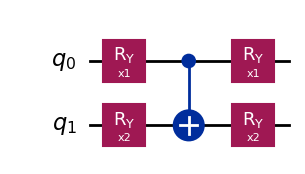

In [5]:
# Feature map 1
def feature_map_ry_cx():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    qc = QuantumCircuit(2)
    qc.ry(x1, 0)
    qc.ry(x2, 1)
    qc.cx(0,1)
    qc.ry(x1,0)
    qc.ry(x2,1)
    return qc

qc1 = feature_map_ry_cx()
qc1.draw('mpl')


## Train QSVM Model 1

In [6]:
# Quantum kernel
quantum_kernel_1 = FidelityQuantumKernel(feature_map=qc1)

# Compute kernel
print(" Computing training kernel for QSVM Model 1...")
kernel_train_1 = quantum_kernel_1.evaluate(x_vec=x_train, y_vec=x_train)

# Train SVM with precomputed kernel
qsvm_model_1 = SVC(kernel='precomputed')
qsvm_model_1.fit(kernel_train_1, y_train)
print(" QSVM Model 1 trained!")

# Train and Test predictions
y_train_pred_q1 = qsvm_model_1.predict(kernel_train_1)
kernel_test_1 = quantum_kernel_1.evaluate(x_vec=x_test, y_vec=x_train)
y_test_pred_q1 = qsvm_model_1.predict(kernel_test_1)

# Accuracy
train_acc_q1 = accuracy_score(y_train, y_train_pred_q1)
test_acc_q1 = accuracy_score(y_test, y_test_pred_q1)
print(f"QSVM Model 1 Train Accuracy: {train_acc_q1*100:.2f}%")
print(f"QSVM Model 1 Test Accuracy: {test_acc_q1*100:.2f}%")


 Computing training kernel for QSVM Model 1...
 QSVM Model 1 trained!
QSVM Model 1 Train Accuracy: 91.25%
QSVM Model 1 Test Accuracy: 85.00%


## QSVM Model 2 (RZ + CX + Layered)

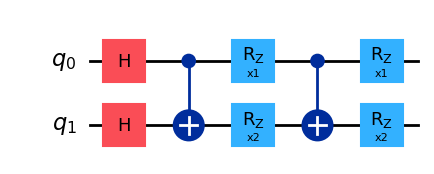

In [7]:
def feature_map_rz_cx_layers():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    qc = QuantumCircuit(2)
    qc.h([0,1])
    qc.cx(0,1)
    qc.rz(x1,0)
    qc.rz(x2,1)
    qc.cx(0,1)
    qc.rz(x1,0)
    qc.rz(x2,1)
    return qc

qc2 = feature_map_rz_cx_layers()
qc2.draw('mpl')


## Train QSVM Model 2

In [8]:
quantum_kernel_2 = FidelityQuantumKernel(feature_map=qc2)

print(" Computing training kernel for QSVM Model 2...")
kernel_train_2 = quantum_kernel_2.evaluate(x_vec=x_train, y_vec=x_train)

qsvm_model_2 = SVC(kernel='precomputed')
qsvm_model_2.fit(kernel_train_2, y_train)

# Predictions
y_train_pred_q2 = qsvm_model_2.predict(kernel_train_2)
kernel_test_2 = quantum_kernel_2.evaluate(x_vec=x_test, y_vec=x_train)
y_test_pred_q2 = qsvm_model_2.predict(kernel_test_2)

# Accuracy
train_acc_q2 = accuracy_score(y_train, y_train_pred_q2)
test_acc_q2 = accuracy_score(y_test, y_test_pred_q2)
print(f"QSVM Model 2 Train Accuracy: {train_acc_q2*100:.2f}%")
print(f"QSVM Model 2 Test Accuracy: {test_acc_q2*100:.2f}%")


 Computing training kernel for QSVM Model 2...
QSVM Model 2 Train Accuracy: 81.25%
QSVM Model 2 Test Accuracy: 85.00%


## Plot Decision Boundaries

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

def fast_plot_decision_boundary(model, x_data, y_data, x_train_ref, title, save_path):
    xx, yy = np.meshgrid(
        np.linspace(x_data[:,0].min()-1, x_data[:,0].max()+1, 40),
        np.linspace(x_data[:,1].min()-1, x_data[:,1].max()+1, 40)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Approximate quantum kernel with a classical RBF kernel (for visualization only)
    kernel_grid = rbf_kernel(grid_points, x_train_ref, gamma=0.5)

    Z = model.predict(kernel_grid).reshape(xx.shape)
    
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="RdBu")
    plt.scatter(x_data[y_data==0,0], x_data[y_data==0,1], color='blue', label='Setosa')
    plt.scatter(x_data[y_data==1,0], x_data[y_data==1,1], color='red', label='Versicolor')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.savefig(save_path)
    plt.show()


## Compare Model Performance

In [12]:
from sklearn.metrics.pairwise import rbf_kernel

def fast_plot_decision_boundary(model, x_data, y_data, x_train_ref, title, save_path):
    xx, yy = np.meshgrid(
        np.linspace(x_data[:,0].min()-1, x_data[:,0].max()+1, 40),
        np.linspace(x_data[:,1].min()-1, x_data[:,1].max()+1, 40)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Approximate quantum kernel with a classical RBF kernel (for visualization only)
    kernel_grid = rbf_kernel(grid_points, x_train_ref, gamma=0.5)

    Z = model.predict(kernel_grid).reshape(xx.shape)
    
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="RdBu")
    plt.scatter(x_data[y_data==0,0], x_data[y_data==0,1], color='blue', label='Setosa')
    plt.scatter(x_data[y_data==1,0], x_data[y_data==1,1], color='red', label='Versicolor')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.savefig(save_path)
    plt.show()



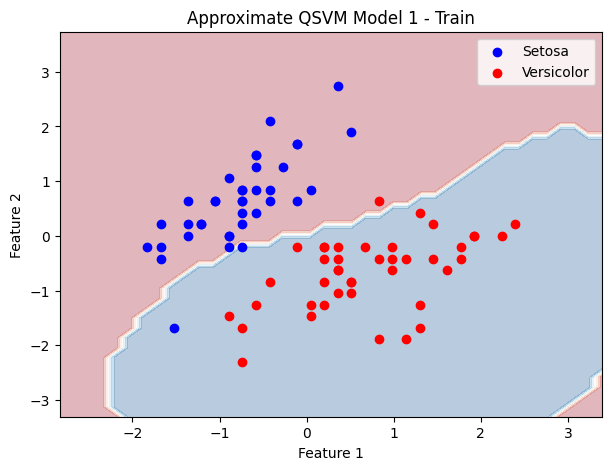

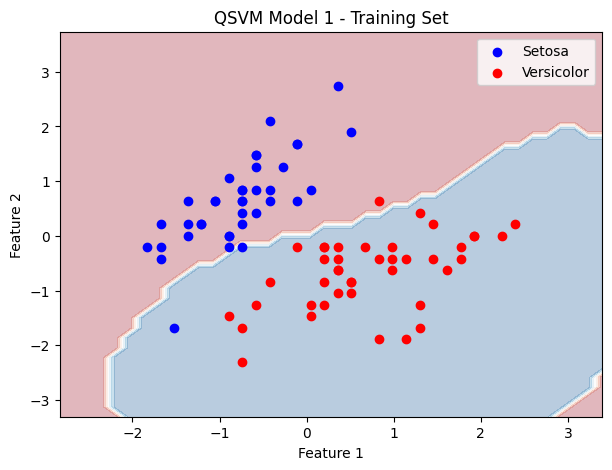

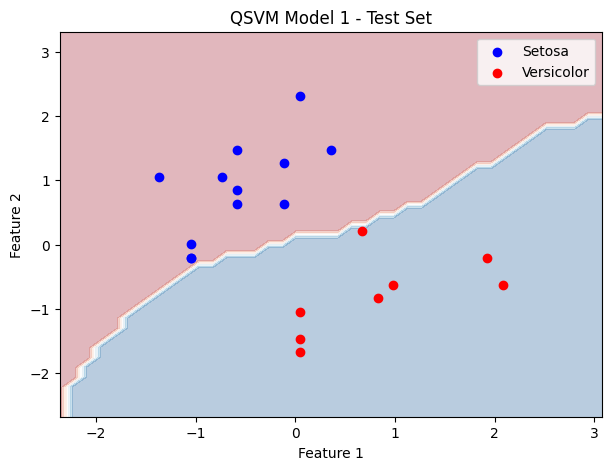

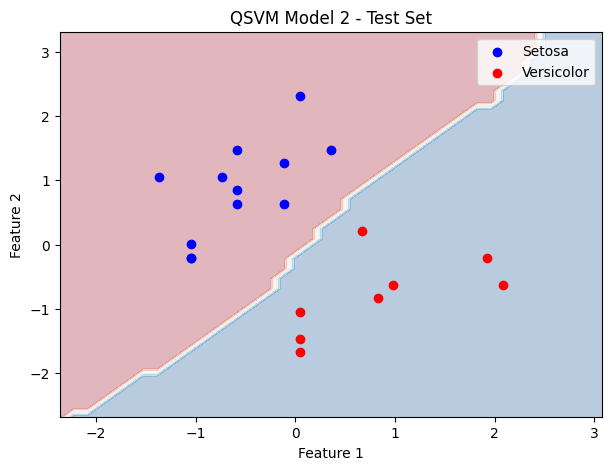

In [ ]:
fast_plot_decision_boundary(qsvm_model_1, x_train, y_train, x_train, "Approximate QSVM Model 1 - Train", "figures/qsvm_fast.png")
fast_plot_decision_boundary(qsvm_model_1, x_train, y_train, x_train,
                            "QSVM Model 1 - Training Set", "figures/qsvm1_train_fast.png")

fast_plot_decision_boundary(qsvm_model_1, x_test, y_test, x_train,
                            "QSVM Model 1 - Test Set", "figures/qsvm1_test_fast.png")

fast_plot_decision_boundary(qsvm_model_2, x_train, y_train, x_train,
                            "QSVM Model 2 - Training Set", "figures/qsvm2_train_fast.png")
fast_plot_decision_boundary(qsvm_model_2, x_test, y_test, x_train,
                            "QSVM Model 2 - Test Set", "figures/qsvm2_test_fast.png")



## Performance Comparison Plot

In [14]:
plt.figure(figsize=(6,4))
plt.bar(df['Model'], [train_acc_q1*100, train_acc_q2*100, accuracy_score(y_train, y_train_pred)*100], alpha=0.7, label='Train')
plt.bar(df['Model'], [test_acc_q1*100, test_acc_q2*100, accuracy_score(y_test, y_test_pred)*100], alpha=0.7, label='Test')
plt.ylabel("Accuracy (%)")
plt.title("QSVM vs Classical SVM Performance")
plt.legend()
plt.savefig("figures/performance_comparison.png")
plt.show()


KeyError: 'Model'

<Figure size 600x400 with 0 Axes>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm  # for progress bar
import time

def plot_all_boundaries(x_train, y_train,
                        classical_model,
                        qsvm_model_1, q_kernel_1,
                        qsvm_model_2, q_kernel_2,
                        cache_dir="kernel_cache",
                        fast_mode=True):
    """
    Compare Classical SVM and QSVM decision boundaries efficiently.

    Parameters
    ----------
    x_train, y_train : np.ndarray
        Training data and labels.
    classical_model : sklearn.svm.SVC
        Trained classical SVM model.
    qsvm_model_1, qsvm_model_2 : SVC
        Trained quantum SVMs using precomputed kernels.
    q_kernel_1, q_kernel_2 : QuantumKernel
        Qiskit quantum kernels used to compute similarity.
    cache_dir : str
        Directory where quantum kernels for visualization are cached.
    fast_mode : bool
        If True, uses a 50x50 grid instead of 200x200 (100× faster).
    """

    # -----------------------------
    # Create cache directory
    # -----------------------------
    os.makedirs(cache_dir, exist_ok=True)

    # -----------------------------
    # Grid for visualization
    # -----------------------------
    grid_size = 50 if fast_mode else 200
    xx, yy = np.meshgrid(
        np.linspace(x_train[:, 0].min() - 1, x_train[:, 0].max() + 1, grid_size),
        np.linspace(x_train[:, 1].min() - 1, x_train[:, 1].max() + 1, grid_size)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    print(f"🟦 Grid size: {grid_size}x{grid_size} ({len(grid)} points)")

    # -----------------------------
    # Classical SVM predictions
    # -----------------------------
    print("📘 Predicting Classical SVM boundaries...")
    Z_classical = classical_model.predict(grid).reshape(xx.shape)

    # -----------------------------
    # Quantum kernel predictions (with caching)
    # -----------------------------
    def compute_or_load_kernel(q_kernel, kernel_name):
        cache_file = os.path.join(cache_dir, f"{kernel_name}.npy")
        if os.path.exists(cache_file):
            print(f"✅ Loaded cached {kernel_name}")
            return np.load(cache_file)
        else:
            print(f"⚙️ Computing {kernel_name} (this may take a while)...")
            start = time.time()
            k_eval = q_kernel.evaluate(x_vec=grid, y_vec=x_train)
            np.save(cache_file, k_eval)
            print(f"✅ Saved {kernel_name} to cache ({time.time()-start:.2f}s)")
            return k_eval

    print("📗 Evaluating QSVM Model 1 kernel...")
    grid_kernel_1 = compute_or_load_kernel(q_kernel_1, "grid_kernel_1")
    print("📙 Evaluating QSVM Model 2 kernel...")
    grid_kernel_2 = compute_or_load_kernel(q_kernel_2, "grid_kernel_2")

    print("📈 Predicting QSVM model boundaries...")
    Z_q1 = qsvm_model_1.predict(grid_kernel_1).reshape(xx.shape)
    Z_q2 = qsvm_model_2.predict(grid_kernel_2).reshape(xx.shape)

    # -----------------------------
    # Plot all decision boundaries
    # -----------------------------
    plt.figure(figsize=(18, 5))

    # Classical SVM
    plt.subplot(1, 3, 1)
    plt.contourf(xx, yy, Z_classical, alpha=0.3, cmap='RdBu')
    plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1],
                color='blue', label='Setosa')
    plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1],
                color='red', label='Versicolor')
    plt.title("Classical SVM - Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()

    # QSVM Model 1
    plt.subplot(1, 3, 2)
    plt.contourf(xx, yy, Z_q1, alpha=0.3, cmap='RdBu')
    plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1],
                color='blue', label='Setosa')
    plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1],
                color='red', label='Versicolor')
    plt.title("QSVM Model 1 - Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # QSVM Model 2
    plt.subplot(1, 3, 3)
    plt.contourf(xx, yy, Z_q2, alpha=0.3, cmap='RdBu')
    plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1],
                color='blue', label='Setosa')
    plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1],
                color='red', label='Versicolor')
    plt.title("QSVM Model 2 - Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    plt.tight_layout()
    plt.savefig("figures/decision_boundary_comparison.png")
    plt.show()

    print("✅ Done! Figure saved at 'figures/decision_boundary_comparison.png'")



another thingggggg

In [ ]:


# ---- 1. Import Libraries ----
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels import FidelityQuantumKernel


# ---- 2. Load Iris Data (two classes only) ----
iris = datasets.load_iris()
X = iris.data[:, :2]  # first two features
Y = iris.target

mask = Y < 2  # keep only Setosa and Versicolor
X = X[mask]
Y = Y[mask]

print(" Data shape:", X.shape)
print(" Classes:", np.unique(Y))

# ---- 3. Normalize ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- 4. Split ----
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)

print("\n Train:", x_train.shape, " Test:", x_test.shape)

# ---- 5. Define Feature Map (2 parameters for 2 features) ----
def feature_map():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    qc = QuantumCircuit(2)
    qc.ry(x1, 0)
    qc.ry(x2, 1)
    qc.cx(0, 1)
    qc.ry(x1, 0)
    qc.ry(x2, 1)
    return qc

qc = feature_map()

# ---- 6. Quantum Kernel ----
quantum_kernel = FidelityQuantumKernel(feature_map=qc)

# ---- 7. Compute Training Kernel ----
print("\n Computing training kernel...")
kernel_train = quantum_kernel.evaluate(x_vec=x_train, y_vec=x_train)

# ---- 8. Train QSVM ----
model = SVC(kernel='precomputed')
model.fit(kernel_train, y_train)
print(" QSVM model trained!")

# ---- 9. Evaluate on Training Data ----
print("\n Evaluating on training set...")
y_train_pred = model.predict(kernel_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f" Training accuracy: {train_acc * 100:.2f}%")
print("Confusion matrix (train):")
print(confusion_matrix(y_train, y_train_pred))

# ---- 10. Evaluate on Test Data ----
print("\n Evaluating on test set...")
kernel_test = quantum_kernel.evaluate(x_vec=x_test, y_vec=x_train)
y_test_pred = model.predict(kernel_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f" Test accuracy: {test_acc * 100:.2f}%")
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ---- 11. Plot Decision Boundaries ----

def plot_decision_boundary(x_data, y_data, title):
    xx, yy = np.meshgrid(
        np.linspace(x_train[:, 0].min() - 1, x_train[:, 0].max() + 1, 100),
        np.linspace(x_train[:, 1].min() - 1, x_train[:, 1].max() + 1, 100)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    kernel_grid = quantum_kernel.evaluate(x_vec=grid_points, y_vec=x_train)
    Z = model.predict(kernel_grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="RdBu")
    plt.scatter(x_data[y_data == 0, 0], x_data[y_data == 0, 1],
                color='blue', label='Setosa')
    plt.scatter(x_data[y_data == 1, 0], x_data[y_data == 1, 1],
                color='red', label='Versicolor')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

#  Plot on training data
plot_decision_boundary(x_train, y_train, " QSVM Decision Boundary (Training Set)")

# 🌿 Plot on test data
plot_decision_boundary(x_test, y_test, " QSVM Decision Boundary (Test Set)")

# ---- 12. Summary ----
print("\n Summary:")
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Testing Accuracy : {test_acc*100:.2f}%")
